In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import datetime
import calendar

from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import cvxpy as cp

import plotly.express as px
import plotly.graph_objects as go

import urllib.request
import json

#### Get S&P 500 tickers

In [2]:
wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = wiki[0]
second_table = wiki[1]

df = first_table
df_date_filter = df[df['Date first added'] < '2016-01-01'].copy()
tickers = df_date_filter.sample(n=50, random_state=3)['Symbol'].to_list()

In [3]:
esg_list = []
e_list = []
s_list = []
g_list = []
missing = []

for ticker in tickers:
    try:
        url = "https://query2.finance.yahoo.com/v1/finance/esgChart?symbol={}".format(ticker)

        connection = urllib.request.urlopen(url)

        data_connection = connection.read()
        data_json = json.loads(data_connection)
        formatdata = data_json["esgChart"]["result"][0]["symbolSeries"]
        df_data = pd.DataFrame(formatdata)
        df_data["timestamp"] = pd.to_datetime(df_data["timestamp"], unit="s")
        df_data = df_data.set_index('timestamp')
        df_data = df_data.loc['2016':'2017']
        esg_list.append(df_data['esgScore'])
        e_list.append(df_data['environmentScore'])
        s_list.append(df_data['socialScore'])
        g_list.append(df_data['governanceScore'])
    except:
        missing.append(ticker)
        continue

if missing != None:
    for tick in missing:
        tickers.remove(tick)

esg_df = pd.concat(esg_list, axis=1)
esg_df.columns = tickers

e_df = pd.concat(e_list, axis=1)
e_df.columns = tickers

s_df = pd.concat(s_list, axis=1)
s_df.columns = tickers

g_df = pd.concat(g_list, axis=1)
g_df.columns = tickers

<AxesSubplot:ylabel='Frequency'>

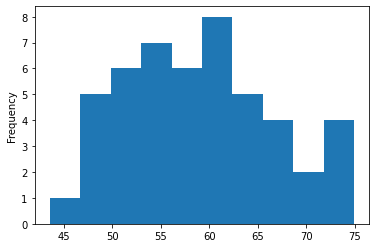

In [4]:
esg_df.mean().plot(kind='hist')

In [5]:
year_start = esg_df.index[0].date().year
month_start = esg_df.index[0].date().month

year_end = esg_df.index[-1].date().year
month_end = esg_df.index[-1].date().month
last_day_date = calendar.monthrange(year_end, month_end)[1]

start = datetime.date(year_start,month_start,1)
end = datetime.date(year_end,month_end,last_day_date)

data_source = 'yahoo'

def get_stocks(ticker, source, start, end):
    stocks_list = []
    for tick in ticker:
        try:
            stocks = DataReader(tick, source, start, end)
            stocks_list.append(stocks[['Close']].add_suffix('_'+tick))
        except:
            continue
    
    all_stocks = pd.concat(stocks_list, axis = 1)
    return all_stocks

# Get Data and clean tickers
stocks = get_stocks(tickers, data_source, start, end)
clean_ticks = list(map(lambda x: x.split('_')[1], stocks.columns))
stocks.columns = clean_ticks

In [6]:
stocks.head()

,EW,LMT,TSN,ALLE,CLX,ADI,LYB,BWA,RSG,SWK,...,GS,HSY,SCHW,CSX,PFG,ORLY,ZION,KMX,JNJ,TRV
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,26.280001,213.210007,52.959999,64.529999,125.279999,54.439999,87.180000,42.250000,43.139999,104.870003,...,177.139999,87.989998,31.980000,8.596667,44.040001,246.110001,26.709999,52.369999,100.480003,109.970001
2016-01-05,26.670000,218.259995,52.299999,64.459999,127.089996,54.040001,87.639999,41.570000,43.840000,102.709999,...,174.089996,87.669998,31.879999,8.510000,44.139999,247.960007,26.420000,52.119999,100.900002,110.470001
2016-01-06,26.813334,217.630005,52.259998,62.770000,127.029999,51.740002,83.510002,40.209999,43.990002,101.290001,...,169.839996,87.730003,30.790001,8.123333,42.320000,241.070007,25.650000,48.310001,100.389999,109.040001
2016-01-07,25.853333,213.289993,52.169998,60.959999,125.639999,50.419998,80.089996,37.709999,44.150002,98.410004,...,164.619995,85.699997,29.180000,7.873333,40.230000,240.169998,24.879999,47.110001,99.220001,106.440002
2016-01-08,25.346666,212.910004,52.299999,59.770000,126.180000,49.980000,79.589996,36.599998,44.130001,96.440002,...,163.940002,84.919998,29.000000,7.826667,40.139999,234.660004,24.600000,46.799999,98.160004,105.989998


In [7]:
esg_tot_sample = esg_df[clean_ticks].copy()
esg_e_sample = e_df[clean_ticks].copy()
esg_s_sample = s_df[clean_ticks].copy()
esg_g_sample = g_df[clean_ticks].copy()

In [8]:
class efficient_frontier():
    def __init__(self, stocks, up_bound, samples, ticks):
        self.stocks = stocks
        self.upper_bound = up_bound
        self.samples = samples
        self.ticks = ticks
    
    def optimize_portfolios(self):
        mu = ema_historical_return(self.stocks)
        s = CovarianceShrinkage(self.stocks).ledoit_wolf()
        n = len(mu)
        upper_bound = self.upper_bound
        w = cp.Variable(n)
        gamma = cp.Parameter(nonneg=True)
        ret = mu.to_numpy().T@w 
        risk = cp.quad_form(w, s.to_numpy())
        prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
                          [cp.sum(w) == 1, w >= 0, w <= upper_bound])
        
        risk_data = np.zeros(self.samples)
        ret_data = np.zeros(self.samples)
        weights_data = []
        gamma_vals = np.logspace(-2, 3, num=self.samples)

        for i in range(self.samples):
            gamma.value = gamma_vals[i]
            prob.solve()
            weights = w
            weights_tick = pd.Series(weights.value, index=self.ticks)
            weights_tick_filter = weights_tick[weights_tick > 1.0e-03]
            weights_data.append(weights_tick_filter)
            risk_data[i] = cp.sqrt(risk).value
            ret_data[i] = ret.value
            
        weights_df = pd.concat(weights_data, axis = 1).T.fillna(0)
        rr_df = pd.DataFrame({'Return': ret_data, 'Risk': risk_data})
        self.portfolios_df = pd.concat([rr_df, weights_df], axis = 1)

In [9]:
conv_frontier = efficient_frontier(stocks.loc['2016'], 0.05, 200, clean_ticks)
conv_frontier.optimize_portfolios()

In [10]:
def screen(esg_df, stocks_df):
    mean_esg = esg_df.mean()
    thresh = mean_esg.quantile(0.3)
    mean_esg = mean_esg[mean_esg > thresh]
    screen_stocks = stocks_df[mean_esg.index]
    screen_ticks = screen_stocks.columns
    return screen_stocks, screen_ticks

In [11]:
# E Screen
e_stocks, e_ticks = screen(esg_e_sample, stocks.loc['2016'])
e_frontier = efficient_frontier(e_stocks, 0.05, 200, e_ticks)
e_frontier.optimize_portfolios()

# S Screen
s_stocks, s_ticks = screen(esg_s_sample, stocks.loc['2016'])
s_frontier = efficient_frontier(s_stocks, 0.05, 200, s_ticks)
s_frontier.optimize_portfolios()

# G Screen
g_stocks, g_ticks = screen(esg_g_sample, stocks.loc['2016'])
g_frontier = efficient_frontier(g_stocks, 0.05, 200, g_ticks)
g_frontier.optimize_portfolios()

# ESG Screen
esg_stocks, esg_ticks = screen(esg_tot_sample, stocks.loc['2016'])
esg_frontier = efficient_frontier(esg_stocks, 0.05, 200, esg_ticks)
esg_frontier.optimize_portfolios()

In [12]:
rr_conv = conv_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_conv['Screen'] = 'No Screen'

rr_e = e_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_e['Screen'] = 'E'

rr_s = s_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_s['Screen'] = 'S'

rr_g = g_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_g['Screen'] = 'G'

rr_esg = esg_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_esg['Screen'] = 'ESG'

rr_all = pd.concat([rr_conv, rr_e, rr_s, rr_g, rr_esg])

In [13]:
px.scatter(rr_all, x='Risk', y='Return', color='Screen', width=1000, height=700)

In [14]:
px.line(rr_all, x='Risk', y='Return', color='Screen', width=1000, height=700)

In [15]:
def get_sharpe_rr_and_weights(df):
    df['Sharpe'] = (df['Return'] - 0.02) / df['Risk']
    sharpe_rr = df.iloc[df['Sharpe'].idxmax()].loc[['Return', 'Risk']]
    sharpe_weights = df.drop(['Return', 'Risk', 'Sharpe'], axis = 1).iloc[df['Sharpe'].idxmax()]
    sharpe_weights = sharpe_weights[sharpe_weights!=0]
    return sharpe_rr, sharpe_weights

In [16]:
conv_sh_rr, conv_sh_w = get_sharpe_rr_and_weights(conv_frontier.portfolios_df)
e_sh_rr, e_sh_w = get_sharpe_rr_and_weights(e_frontier.portfolios_df)
s_sh_rr, s_sh_w = get_sharpe_rr_and_weights(s_frontier.portfolios_df)
g_sh_rr, g_sh_w = get_sharpe_rr_and_weights(g_frontier.portfolios_df)
esg_sh_rr, esg_sh_w = get_sharpe_rr_and_weights(esg_frontier.portfolios_df)

In [17]:
sh_rr_all = pd.concat([conv_sh_rr, e_sh_rr, s_sh_rr, g_sh_rr, esg_sh_rr], axis=1).T
sh_rr_all['Screen'] = ['No Screen', 'E', 'G', 'S', 'ESG']
sh_rr_all

,Return,Risk,Screen
127,0.499410,0.123851,No Screen
124,0.425254,0.125044,E
125,0.476104,0.126607,G
124,0.466611,0.129833,S
125,0.452717,0.125681,ESG


In [18]:
fig = px.line(rr_all, x='Risk', y='Return', color='Screen')
fig.add_trace(
    go.Scatter(
        x=sh_rr_all['Risk'],
        y=sh_rr_all['Return'],
        mode='markers',
        marker=dict(
            color='LightSkyBlue',
            size=8,
            line=dict(
                color='MediumPurple',
                width=2
            )
        ),
        marker_symbol='cross-dot',
        showlegend=False,
    )
)
fig.update_layout(
    width=1000,
    height=700,
)
fig.show()

In [19]:
def compute_sh_portfolio(df, ticks, weights):
    stock_rets = df[ticks].pct_change().fillna(0)
    weighted_stock_rets = stock_rets * weights
    port_rets = weighted_stock_rets.sum(axis=1)
    cum_port_rets = (port_rets + 1).cumprod()
    return port_rets, cum_port_rets

In [20]:
conv_sh_rets, conv_sh_port = compute_sh_portfolio(stocks.loc['2016'], conv_sh_w.index, conv_sh_w.values)
# conv_sh_port.plot()

e_sh_rets, e_sh_port = compute_sh_portfolio(stocks.loc['2016'], e_sh_w.index, e_sh_w.values)
# e_sh_port.plot()

g_sh_rets, g_sh_port = compute_sh_portfolio(stocks.loc['2016'], g_sh_w.index, g_sh_w.values)
# g_sh_port.plot()

s_sh_rets, s_sh_port = compute_sh_portfolio(stocks.loc['2016'], s_sh_w.index, s_sh_w.values)
# s_sh_port.plot()

esg_sh_rets, esg_sh_port = compute_sh_portfolio(stocks.loc['2016'], esg_sh_w.index, esg_sh_w.values)
# esg_sh_port.plot()

In [21]:
all_sh_port = pd.concat([conv_sh_port,e_sh_port, s_sh_port, g_sh_port, esg_sh_port], axis = 1)
all_sh_port.columns = ['No Screen', 'E', 'S', 'G', 'ESG']
all_sh_port.head()

,No Screen,E,S,G,ESG
Date,,,,,
2016-01-04,1.000000,1.000000,1.000000,1.000000,1.000000
2016-01-05,0.998304,1.002018,1.000457,1.000309,0.999228
2016-01-06,0.984998,0.985214,0.984011,0.981523,0.982726
2016-01-07,0.966110,0.963064,0.962872,0.960981,0.960480
2016-01-08,0.958186,0.956559,0.955695,0.953938,0.954316


In [22]:
fig = px.line(all_sh_port, x=all_sh_port.index, y=all_sh_port.columns)
fig.update_layout(
    width=1000,
    height=700,
)

In [26]:
stocks_oof = stocks.loc['2017'].copy()

conv_sh_rets_oof, conv_sh_port_oof = compute_sh_portfolio(stocks_oof, conv_sh_w.index, conv_sh_w.values)
# conv_sh_port.plot()

e_sh_rets_oof, e_sh_port_oof = compute_sh_portfolio(stocks_oof, e_sh_w.index, e_sh_w.values)
# e_sh_port.plot()

g_sh_rets_oof, g_sh_port_oof = compute_sh_portfolio(stocks_oof, g_sh_w.index, g_sh_w.values)
# g_sh_port.plot()

s_sh_rets_oof, s_sh_port_oof = compute_sh_portfolio(stocks_oof, s_sh_w.index, s_sh_w.values)
# s_sh_port.plot()

esg_sh_rets_oof, esg_sh_port_oof = compute_sh_portfolio(stocks_oof, esg_sh_w.index, esg_sh_w.values)
# esg_sh_port.plot()

all_sh_port_oof = pd.concat([conv_sh_port_oof,e_sh_port_oof, s_sh_port_oof, g_sh_port_oof, esg_sh_port_oof], axis = 1)
all_sh_port_oof.columns = ['No Screen', 'E', 'S', 'G', 'ESG']
all_sh_port_oof.head()

,No Screen,E,S,G,ESG
Date,,,,,
2017-01-03,1.000000,1.000000,1.000000,1.000000,1.000000
2017-01-04,1.007032,1.008195,1.006013,1.008812,1.007534
2017-01-05,1.003788,1.004420,0.999973,1.005257,1.002998
2017-01-06,1.007599,1.008514,1.004512,1.007975,1.007133
2017-01-09,1.002746,1.006128,0.999713,1.004348,1.003954


In [27]:
fig = px.line(all_sh_port_oof, x=all_sh_port_oof.index, y=all_sh_port_oof.columns)
fig.update_layout(
    width=1000,
    height=700,
)